In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
import time
from scipy.sparse import coo_matrix
from shapely.geometry import Point, LineString, MultiLineString
from shapely import ops
import networkx as nx
import matplotlib.pyplot as plt
import folium
import pickle
import warnings
import sys

warnings.filterwarnings('ignore')

print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
# add paths for modules
sys.path.append('../src/models')
sys.path.append('../src/visualization')
sys.path.append('../src/features')
# import modules
import visualize
import geometry_utils
from maritime_traffic_network import MaritimeTrafficNetwork

In [3]:
# load network from pickle
model = "['202204', '202208']_waypoints_DP30_HDBSCAN30_stavanger_full_UTM"
model_path = '../models/networks/' + model + '.obj'
fileObj = open(model_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()

In [4]:
network.get_trajectories_info()
network.hyperparameters

Number of AIS messages: 12121380
Number of trajectories: 38835
Coordinate Reference System (CRS): EPSG:32632


{'Data': "['../../data/processed/202204_points_stavanger_cleaned_meta_full_dualSplit_3.parquet', '../../data/processed/202208_points_stavanger_cleaned_meta_full_dualSplit_3.parquet']",
 'DP_tolerance': 30,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 30,
 'clustering_min_cluster_size': 30,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.01, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]),
 'graph_generation_max_distance': 20,
 'graph_generation_max_angle': 45,
 'merge_stops_speed': 2}

In [5]:
network.prune_graph(1)
merge_stops = True
merge_stops_speed = 2
network.merge_stop_points(max_speed=merge_stops_speed)
pruning = 1
network.prune_graph(pruning)

Pruning...
------------------------
Pruned Graph:
Number of nodes: 1192 (8 isolated)
Number of edges: 6019
------------------------
Pruning...
------------------------
Pruned Graph:
Number of nodes: 1190 (8 isolated)
Number of edges: 6010
------------------------


In [6]:
# load evaluation data
eval_file = '202205_points_stavanger_cleaned_meta_full_dualSplit_3'
filename = '../data/processed/' + eval_file + '.parquet'
gdf = gpd.read_parquet(filename)
crs = 32632  # Coordinate reference system
gdf.to_crs(crs, inplace=True)  # Transformation
all_trajectories = mpd.TrajectoryCollection(gdf, traj_id_col='mmsi', obj_id_col='mmsi')

# select evaluation data
selection_start = 0
selection_end = len(all_trajectories)
selection_step = 1
selection = np.arange(selection_start, selection_end, selection_step)
n_trajectories = len(selection)
mmsis = gdf.mmsi.unique()[selection]
trajectories = all_trajectories.filter('mmsi', mmsis.tolist())

Evaluating graph on 20010 trajectories
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done! Time elapsed for evaluation: 911.09 minutes
Success rates:
                   mmsi      SSPD  distances  fraction_covered      path  path_linestring
message                                                                                  
attempt        0.013393  0.013393   0.013393          0.013393  0.013393         0.013393
no_intersects  0.061069  0.000000   0.000000          0.061069  0.000000         0.000000
no_path        0.038131  0.000000   0.000000          0.038131  0.000000         0.000000
success        0.887406  0.887406   0.887406          0.887406  0.887406         0.887406

 --------------------------- 

Fraction of NaN results: 0.099

 --------------------------- 

Mean fraction of each trajectory covered by the path on the graph: 0.898 

Mean distance      = 297.00 m
Median distance    = 78.37 m
Standard deviation = 883.19 m 



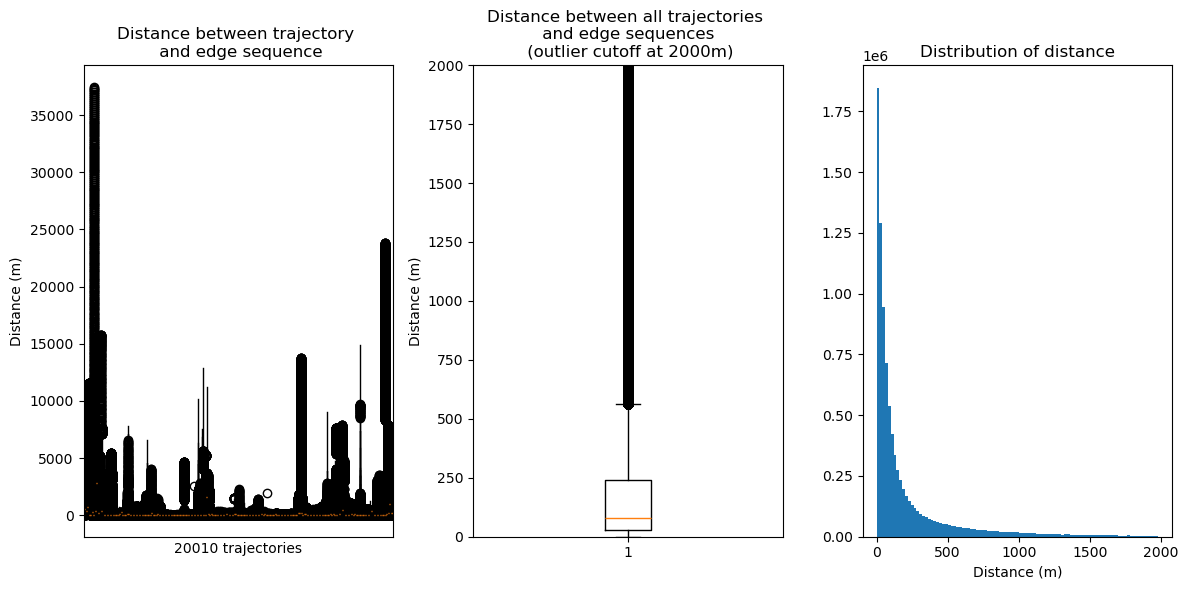

In [7]:
# evaluate network
all_paths, all_evaluation_results, summary, fig = network.evaluate_graph(trajectories)

In [8]:
#mmsis = ['258002060_1070_2022-05-22 22:24:23', '258002060_928_2022-05-19 18:03:55']
#trajectories = trajectories.filter('mmsi', mmsis)

In [9]:
#for trajectory in trajectories:
#    path, eval = network.trajectory_to_path2(trajectory)

In [10]:
# Generate plot
#map = network.map_graph(pruned=True)
#map = trajectories.to_line_gdf()[['geometry', 'mmsi']].explore(m=map, style_kwds={'weight':1, 'color':'black', 'opacity':0.5}, 
#                                                               name='trajectories')
#map = all_paths.explore(m=map, color='yellow', name='paths')
#folium.LayerControl().add_to(map)

#map

In [11]:
#map.save('dummy2.html')

In [12]:
"""
# Save experiment results with neptune
import neptune


run = neptune.init_run(
    project="jandrik91/Maritime-Traffic-Network",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxYmQzMjgwZS1jZGYwLTQ2YjktYWNjOS02MjBlZWEzNzUzNDcifQ==",
)  # your credentials

run["model"]=model
run["algorithm"]='V7.0(SSPD)'
run["n_points"]=len(network.gdf)
run["n_nodes"]=network.G_pruned.number_of_nodes()
run["n_edges"]=network.G_pruned.number_of_edges()
run["n_isolated"]=nx.number_of_isolates(network.G_pruned)
run["merge_stops"] = merge_stops
run["merge_stops_speed"] = merge_stops_speed
run["pruning"] = pruning

params = network.hyperparameters
params['clustering_metric_V_coord'] = params['clustering_metric_V'][0][0]
params['clustering_metric_V_cog'] = params['clustering_metric_V'][2][2]
params['clustering_metric_V_speed'] = params['clustering_metric_V'][4][4]
run["parameters"] = params

run["test_data"] = {'eval_file':eval_file,
                    'selection_start':selection_start,
                    'selection_end':selection_end,
                    'selection_step':selection_step,
                    'n_trajectories':n_trajectories}

run["plot"].upload(fig)
run["summary"] = summary

run.stop()
"""

'\n# Save experiment results with neptune\nimport neptune\n\n\nrun = neptune.init_run(\n    project="jandrik91/Maritime-Traffic-Network",\n    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxYmQzMjgwZS1jZGYwLTQ2YjktYWNjOS02MjBlZWEzNzUzNDcifQ==",\n)  # your credentials\n\nrun["model"]=model\nrun["algorithm"]=\'V7.0(SSPD)\'\nrun["n_points"]=len(network.gdf)\nrun["n_nodes"]=network.G_pruned.number_of_nodes()\nrun["n_edges"]=network.G_pruned.number_of_edges()\nrun["n_isolated"]=nx.number_of_isolates(network.G_pruned)\nrun["merge_stops"] = merge_stops\nrun["merge_stops_speed"] = merge_stops_speed\nrun["pruning"] = pruning\n\nparams = network.hyperparameters\nparams[\'clustering_metric_V_coord\'] = params[\'clustering_metric_V\'][0][0]\nparams[\'clustering_metric_V_cog\'] = params[\'clustering_metric_V\'][2][2]\nparams[\'clustering_metric_V_speed\'] = params[\'clustering_metric_V\'][4][4]\nrun["parameters"] = para

In [13]:
all_evaluation_results.rename(columns={'mmsi':'id'}, inplace=True)
all_evaluation_results['mmsi'] = all_evaluation_results['id'].str[:9].astype(int)

In [14]:
sys.path.append('../src/datawrangling')
from make_trajectories_from_AIS import add_ship_metadata
meta_file = '../data/external/seilas-2022.csv'
all_evaluation_results_meta = add_ship_metadata(meta_file, all_evaluation_results)

Geopandas has version 0.13.2
Movingpandas has version 0.17.1
Ship metadata has   4142 unique MMSIs
AIS raw data has    671 unique MMSIs
Overlap:            614 MMSIs


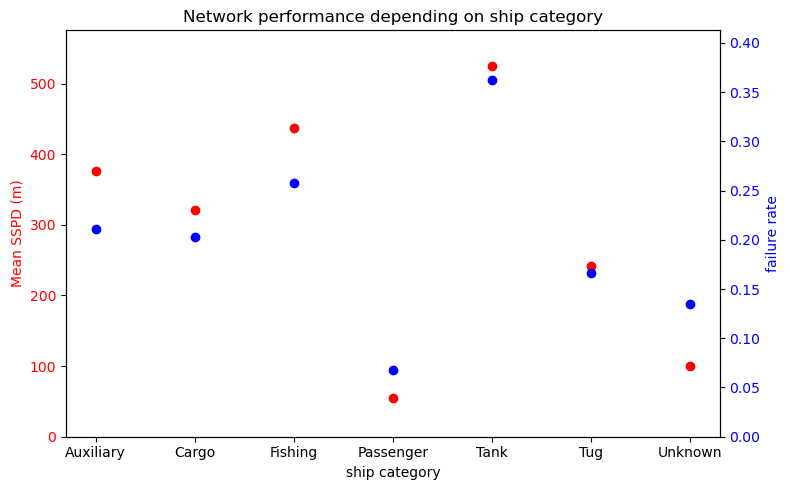

In [15]:
# plot failure rate and MAE by shipgroup
mae_by_group = all_evaluation_results_meta.groupby(['skipsgruppe'])['SSPD'].mean()
success_by_group = all_evaluation_results_meta[all_evaluation_results_meta.message=='success'].groupby(['skipsgruppe'])['message'].count()
msg_by_group = all_evaluation_results_meta.groupby(['skipsgruppe'])['message'].count()
failure_by_group = 1 - success_by_group / msg_by_group

x = mae_by_group.index

fig, ax1 = plt.subplots(figsize=[8, 5])


ax1.set_xlabel('ship category')
ax1.set_ylabel('Mean SSPD (m)', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax2 = ax1.twinx()
ax2.set_ylabel('failure rate', color='blue') 
ax2.tick_params(axis='y', labelcolor='blue')

y1 = mae_by_group.values
y2 = failure_by_group.values

# Set the limits for the y-axes
max_y1_value = max(y1)
max_y2_value = max(y2)
ax1.set_ylim(0, max_y1_value+50)
ax2.set_ylim(0, max_y2_value+0.05)

# plot
ax1.scatter(x, y1, color='red')
ax2.scatter(x, y2, color='blue')

plt.title('Network performance depending on ship category')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig('min_samples.png')
fig.show()

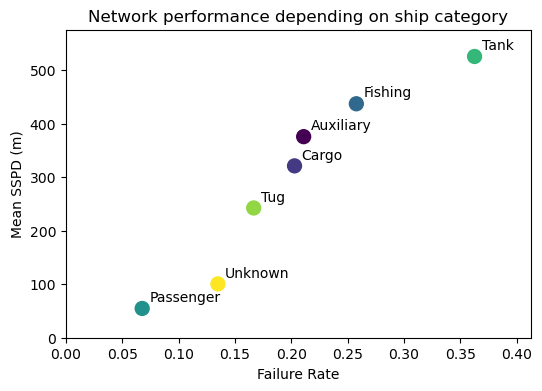

In [21]:
x = failure_by_group.values
y = mae_by_group.values
categories = mae_by_group.index

fig, ax = plt.subplots(figsize=[6, 4])

# Scatter plot with different colors and markers for each category
scatter = ax.scatter(x, y, c=range(len(categories)), cmap='viridis', marker='o', s=100)

# Annotate each point with the ship category name
for i, category in enumerate(categories):
    ax.annotate(category, (x[i], y[i]), textcoords="offset points", xytext=(5,5), ha='left')

max_x_value = max(x)
max_y_value = max(y)
ax.set_xlim(0, max_x_value+0.05)
ax.set_ylim(0, max_y_value+50)

ax.set_xlabel('Failure Rate')
ax.set_ylabel('Mean SSPD (m)')
plt.title('Network performance depending on ship category')
plt.savefig('Network_performance_by_ship_category.pdf')

plt.show()